In [1]:
#!ls ~/trained_models/
import pandas as pd
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

In [2]:
from pathlib import Path
from datatype_recovery.models.dataset import load_dataset_from_path
from datatype_recovery.models.dataset.encoding import *

In [3]:
# dataset_path = Path.home()/'datasets/test_ds'
# dataset_path = Path.home()/'datasets/trainset_astera_full_5hops_nocomp'

# dataset_path = Path.home()/'datasets/coreutils_full_5hops'
dataset_path = Path.home()/'datasets/stateformer33'

# model_path = Path.home()/'trained_models/RERUN_structural_3out_4hops_nocomp.pt'
# model_path = Path.home()/'trained_models/withedges_4out_4hops_nocomp.pt'
# model_path = Path.home()/'trained_models/dragon_4out_5hops_coreutils__COPY.pt'

# model_path = Path.home()/'trained_models/dragon_5hops_ffmpeg__COPY.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_ffmpeg_balanced__EPOCH42.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_256ch_balanced.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_32ch_balanced.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_64ch_balanced.pt'
# model_path = Path.home()/'trained_models/dragon_5hops_5heads_3linear/dragon_5hops_5heads_3linear_ep50.pt'
model_path = Path.home()/'trained_models/dragon_5hops_5heads_3linear__trainset_new_ep50.pt'

# eval_model_on_dataset(model_path, 'cuda:3', dataset_path)

In [4]:
dataset = load_dataset_from_path(dataset_path)
from datatype_recovery.models.dataset import InMemTypeSequenceDataset
df = dataset.read_vars_csv()
df

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip
0,1063561,"1066,1079",uVar1,uint32,register,eax,0.0,BUILTIN,uint32,uVar1,...,eax,0.0,BUILTIN,uint32,False,"{""kind"": ""Builti...",1000,l,False,False
1,1063561,"1113,1124,1150",uVar2,uint64,register,rax,0.0,BUILTIN,uint64,eVar2,...,eax,0.0,BUILTIN,int32,False,"{""kind"": ""Builti...",1000,l,False,False
2,1063561,"363,367,377,392",dVar3,double,register,xmm0_qa,4608.0,BUILTIN,double,dVar4,...,xmm0_qa,4608.0,BUILTIN,double,False,"{""kind"": ""Builti...",1000,l,False,False
3,1063561,"264,296,330,775,810",local_20,char*,stack,NaN,-32.0,PTR,"PTR,char",endptr,...,NaN,-32.0,PTR,"PTR,char",True,"{""kind"": ""Pointe...",1000,l,False,False
4,1063561,"278,363",local_18,double,stack,NaN,-24.0,BUILTIN,double,v,...,NaN,-24.0,BUILTIN,double,True,"{""kind"": ""Builti...",1000,l,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955410,1107165,"43,87",param_2,int32,register,esi,48.0,BUILTIN,int32,cmd,...,esi,48.0,BUILTIN,int32,True,"{""kind"": ""Builti...",33200,p,False,False
955411,1107259,30,param_1,BIO*,register,rdi,56.0,PTR,"PTR,STRUCT",b,...,rdi,56.0,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",33200,p,False,False
955412,1107316,30,param_1,BIO*,register,rdi,56.0,PTR,"PTR,STRUCT",b,...,rdi,56.0,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",33200,p,False,False
955413,1107374,71,param_1,uint64,register,rdi,56.0,BUILTIN,uint64,b,...,rdi,56.0,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",33200,p,False,False


In [5]:
from datatype_recovery.models.eval import make_predictions_on_dataset

max_true_len = df.TypeSeq_Debug.apply(lambda ts: len(ts.split(','))).max()
model_pred = make_predictions_on_dataset(model_path, 'cpu', dataset, max_true_len)
model_pred

DragonModel(
  (gat_layers): ModuleList(
    (0): GATConv(133, 128, heads=5)
    (1-4): 4 x GATConv(640, 128, heads=5)
  )
  (pred_head): Sequential(
    (0): Linear(in_features=640, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(128, 92, bias=True)
  )
)
Running eval...


100%|██████████| 1889/1889 [27:34<00:00,  1.14it/s]


,BinaryId,FunctionStart,Signature,Vartype,RawPred,Pred
0,1000,1063561,"1066,1079",l,uint32,uint32
1,1000,1063561,"1113,1124,1150",l,uint64,uint64
2,1000,1063561,"363,367,377,392",l,double,double
3,1000,1063561,"264,296,330,775,810",l,"PTR,char","PTR,char"
4,1000,1063561,"278,363",l,double,double
...,...,...,...,...,...,...
955410,33200,1107374,"71,76",l,int32,int32
955411,33200,1107374,"42,71",l,uint64,uint64
955412,33200,1107374,"50,80,112",l,"PTR,STRUCT","PTR,STRUCT"
955413,33200,1107374,71,p,"PTR,STRUCT","PTR,STRUCT"


In [6]:
# !pip install -U torch_geometric
!pip list | grep torch

torch                     2.1.0+cu118
torch_geometric           2.5.0
torchaudio                2.1.0+cu118
torchsummary              1.5.1
torchvision               0.16.0+cu118


In [7]:
mdf = df.merge(model_pred, how='right', on=['BinaryId','FunctionStart','Signature','Vartype'])
mdf

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,RawPred,Pred
0,1063561,"1066,1079",uVar1,uint32,register,eax,0.0,BUILTIN,uint32,uVar1,...,BUILTIN,uint32,False,"{""kind"": ""Builti...",1000,l,False,False,uint32,uint32
1,1063561,"1113,1124,1150",uVar2,uint64,register,rax,0.0,BUILTIN,uint64,eVar2,...,BUILTIN,int32,False,"{""kind"": ""Builti...",1000,l,False,False,uint64,uint64
2,1063561,"363,367,377,392",dVar3,double,register,xmm0_qa,4608.0,BUILTIN,double,dVar4,...,BUILTIN,double,False,"{""kind"": ""Builti...",1000,l,False,False,double,double
3,1063561,"264,296,330,775,810",local_20,char*,stack,NaN,-32.0,PTR,"PTR,char",endptr,...,PTR,"PTR,char",True,"{""kind"": ""Pointe...",1000,l,False,False,"PTR,char","PTR,char"
4,1063561,"278,363",local_18,double,stack,NaN,-24.0,BUILTIN,double,v,...,BUILTIN,double,True,"{""kind"": ""Builti...",1000,l,False,False,double,double
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955410,1107374,"71,76",iVar1,int32,register,eax,0.0,BUILTIN,int32,iVar1,...,BUILTIN,int32,False,"{""kind"": ""Builti...",33200,l,False,False,int32,int32
955411,1107374,"42,71",sVar2,uint64,register,rax,0.0,BUILTIN,uint64,size,...,BUILTIN,uint64,False,"{""kind"": ""Builti...",33200,l,False,False,uint64,uint64
955412,1107374,"50,80,112",local_18,uint64,stack,NaN,-24.0,BUILTIN,uint64,m,...,BUILTIN,uint64,True,"{""kind"": ""Builti...",33200,l,False,False,"PTR,STRUCT","PTR,STRUCT"
955413,1107374,71,param_1,uint64,register,rdi,56.0,BUILTIN,uint64,b,...,PTR,"PTR,STRUCT",True,"{""kind"": ""Pointe...",33200,p,False,False,"PTR,STRUCT","PTR,STRUCT"


In [8]:
# compute accuracy for levels 1-3 (first type element only, first two elements, etc...)
for i in range(4):
    mdf[f'TypeSeqL{i+1}_Debug'] = mdf.TypeSeq_Debug.apply(lambda x: ",".join(x.split(',')[:i+1]))
    mdf[f'PredL{i+1}'] = mdf.Pred.apply(lambda x: ",".join(x.split(',')[:i+1]))

In [9]:
acc_corrected = len(mdf[mdf.TypeSeq_Debug==mdf.Pred])/len(mdf)*100
print(f'Accuracy (corrected): {acc_corrected:.2f}%')

# TODO: confusion matrix, F1, precision, recall from this mdf too

Accuracy (corrected): 54.96%


In [10]:
acc_data = []
for i in range(4):
    acc_i = len(mdf[mdf[f'TypeSeqL{i+1}_Debug']==mdf[f'PredL{i+1}']])/len(mdf)*100
    print(f'Level-{i+1} Accuracy (corrected): {acc_i:.2f}%')
    # acc_data.append((f'Level-{i+1} Accuracy', acc_i))
    acc_data.append((i+1, acc_i))

Level-1 Accuracy (corrected): 73.64%
Level-2 Accuracy (corrected): 55.96%
Level-3 Accuracy (corrected): 54.96%
Level-4 Accuracy (corrected): 54.96%


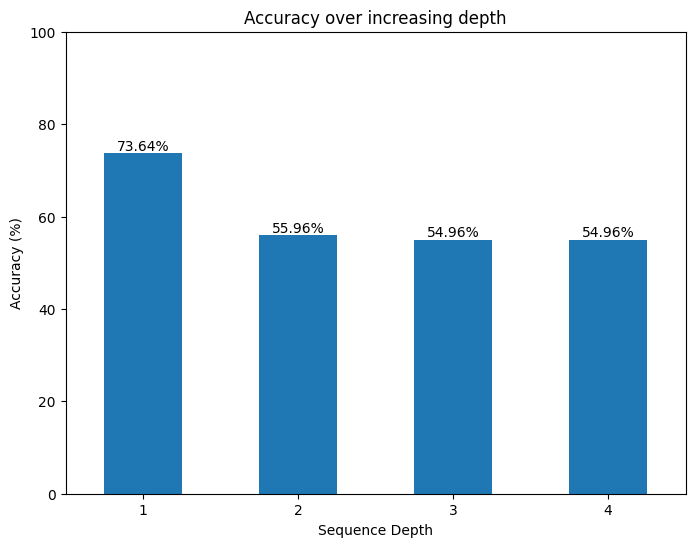

In [11]:
ax = pd.DataFrame(acc_data, columns=['Seq Depth','Accuracy']).plot(kind='bar', x='Seq Depth', y='Accuracy', rot=0, figsize=(8,6),
    xlabel='Sequence Depth', ylabel='Accuracy (%)', title='Accuracy over increasing depth', legend=False,
    ylim=[0, 100])

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt=lambda x: f'{x:.2f}%' if x > 5 else '')


In [12]:
category = 'uchar'
print(f'{len(mdf[mdf.TypeSeqL1_Debug==category]):,} samples')
len(mdf[(mdf.TypeSeqL1_Debug==mdf.PredL1)&(mdf.TypeSeqL1_Debug==category)])/len(mdf[mdf.TypeSeqL1_Debug==category])*100

9,109 samples


86.79328137007354

Text(0, 0.5, 'Accuracy (%)')

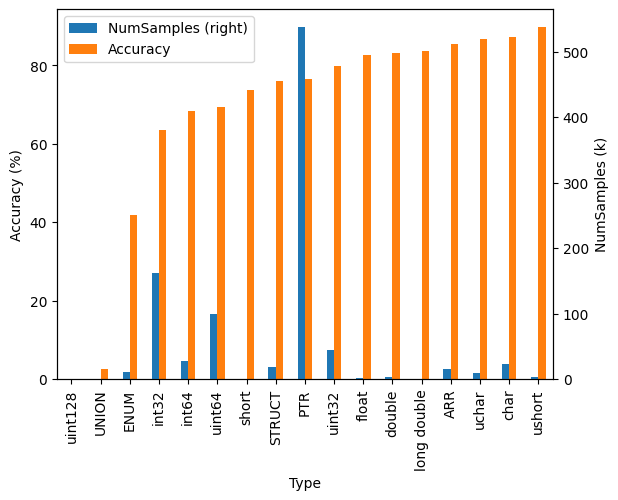

In [13]:
adf = pd.DataFrame(mdf.groupby('TypeSeqL1_Debug').pipe(lambda gb: [(val, len(df)/1000, len(df[df.TypeSeqL1_Debug==df.PredL1])/len(df)*100) for val, df in gb]), columns=['Type', 'NumSamples', 'Accuracy'])\
    .set_index('Type')\
    .sort_values('Accuracy')

ax = adf.plot(kind='bar', secondary_y='NumSamples', ylabel='NumSamples (k)')
ax.set_ylabel('Accuracy (%)')
# adf.plot(kind='bar', y='NumSamples', ax=ax, secondary_y=True)

Text(0, 0.5, 'Accuracy (%)')

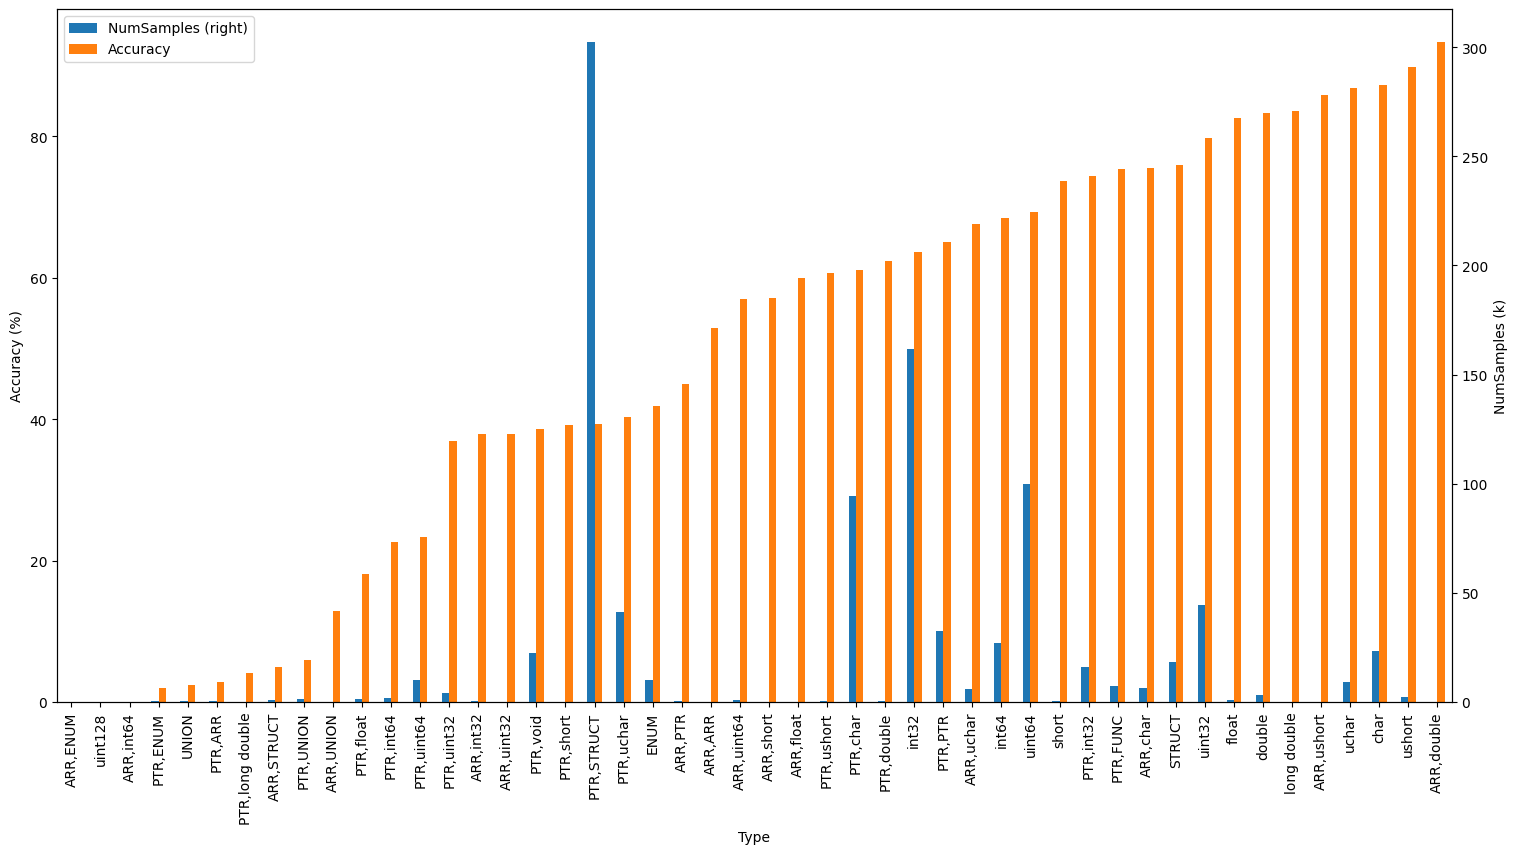

In [14]:
adf = pd.DataFrame(mdf.groupby('TypeSeqL2_Debug').pipe(lambda gb: [(val, len(df)/1000, len(df[df.TypeSeqL2_Debug==df.PredL2])/len(df)*100) for val, df in gb]), columns=['Type', 'NumSamples', 'Accuracy'])\
    .set_index('Type')\
    .sort_values('Accuracy')

ax = adf.plot(kind='bar', secondary_y='NumSamples', ylabel='NumSamples (k)', figsize=(18,9))
ax.set_ylabel('Accuracy (%)')

In [15]:
def calc_accuracy(df):
    return len(df[df.TypeSeq_Debug==df.Pred])/len(df)*100

# calc_accuracy(mdf[mdf.LocType_Debug=='register'])
# calc_accuracy(mdf[mdf.HasDWARF])

mdf.groupby('HasDWARF').pipe(lambda gb: pd.DataFrame([(val, calc_accuracy(df)) for val, df in gb], columns=['HasDWARF', 'Accuracy']))#.plot(kind='bar')

,HasDWARF,Accuracy
0,False,62.571803
1,True,50.061310


In [59]:
#TypeSequence().model_type_elements
[",".join(x) for x in TypeSequence().valid_type_sequences_for_len(4)]

['float',
 'double',
 'long double',
 'char',
 'short',
 'int32',
 'int64',
 'int128',
 'uchar',
 'ushort',
 'uint32',
 'uint64',
 'uint128',
 'uint256',
 'uint512',
 'STRUCT',
 'UNION',
 'ENUM',
 'ARR,float',
 'ARR,double',
 'ARR,long double',
 'ARR,char',
 'ARR,short',
 'ARR,int32',
 'ARR,int64',
 'ARR,int128',
 'ARR,uchar',
 'ARR,ushort',
 'ARR,uint32',
 'ARR,uint64',
 'ARR,uint128',
 'ARR,uint256',
 'ARR,uint512',
 'ARR,STRUCT',
 'ARR,UNION',
 'ARR,ENUM',
 'PTR,float',
 'PTR,double',
 'PTR,long double',
 'PTR,char',
 'PTR,short',
 'PTR,int32',
 'PTR,int64',
 'PTR,int128',
 'PTR,uchar',
 'PTR,ushort',
 'PTR,uint32',
 'PTR,uint64',
 'PTR,uint128',
 'PTR,uint256',
 'PTR,uint512',
 'PTR,void',
 'PTR,STRUCT',
 'PTR,UNION',
 'PTR,ENUM',
 'PTR,FUNC',
 'ARR,ARR,float',
 'ARR,ARR,double',
 'ARR,ARR,long double',
 'ARR,ARR,char',
 'ARR,ARR,short',
 'ARR,ARR,int32',
 'ARR,ARR,int64',
 'ARR,ARR,int128',
 'ARR,ARR,uchar',
 'ARR,ARR,ushort',
 'ARR,ARR,uint32',
 'ARR,ARR,uint64',
 'ARR,ARR,uint12

In [17]:
dataset.read_binaries_csv()

,BinaryId,Name,RunGid,OrigBinaryId
0,1000,ping,0,0
1,1001,ping6,0,1
2,1002,ftp,0,2
3,1003,ifconfig,0,3
4,1004,identify,0,4
...,...,...,...,...
684,33196,verify_extra_test,32,196
685,33197,secmemtest,32,197
686,33198,buildtest_c_ossl...,32,198
687,33199,bioprinttest,32,199


In [18]:
mdf[mdf.Pred!=mdf.TypeSeq_Debug][['BinaryId','FunctionStart','Signature','Name_Debug','Name_Strip','LocType_Strip','TypeSeq_Debug','Pred']]

,BinaryId,FunctionStart,Signature,Name_Debug,Name_Strip,LocType_Strip,TypeSeq_Debug,Pred
1,1000,1063561,"1113,1124,1150",eVar2,uVar2,register,int32,uint64
7,1000,1063561,"330,1108",state,param_3,register,"PTR,STRUCT",uint64
8,1000,1064712,"80,85,243,250",_Var1,_Var1,register,uint32,ENUM
13,1000,1064712,"649,662,670,691",argv_local,local_38,stack,"PTR,PTR,char","PTR,PTR,STRUCT"
16,1000,1064712,"34,221,399",one,local_18,stack,int32,uint32
...,...,...,...,...,...,...,...,...
955392,33200,1106745,"39,71",m,local_18,stack,uint64,int64
955393,33200,1106745,"58,71",n,param_3,register,uint64,int64
955400,33200,1106856,"184,220",buf,param_2,register,"PTR,char",int64
955402,33200,1106856,"274,299",in_size,param_4,register,"PTR,uint64","PTR,PTR,void"


In [19]:
xdf = mdf[mdf.TypeSeq_Debug=='PTR,STRUCT']
xdf.groupby('Vartype').count()/len(xdf)*100
xdf[xdf.TypeSeq_Debug!=xdf.Pred].groupby('LocType_Debug').count()
xdf = xdf[xdf.TypeSeq_Debug!=xdf.Pred][['Pred','TypeSeq_Debug','Signature']]
xdf['NumRefs'] = xdf.Signature.apply(lambda s: len(s.strip(',')))
xdf.sort_values('NumRefs')

,Pred,TypeSeq_Debug,Signature,NumRefs
309355,"PTR,void","PTR,STRUCT",8,1
228258,"PTR,void","PTR,STRUCT",8,1
186412,"PTR,void","PTR,STRUCT",8,1
239865,"PTR,void","PTR,STRUCT",8,1
211697,"PTR,void","PTR,STRUCT",8,1
...,...,...,...,...
88415,"PTR,int32","PTR,STRUCT","63,198,244,297,3...",2636
473453,int64,"PTR,STRUCT","865,975,1099,123...",3180
414659,int64,"PTR,STRUCT","80,128,183,238,2...",3577
398955,"PTR,uint32","PTR,STRUCT","67,159,171,213,2...",3751


In [20]:
mdf.groupby('TypeSeq_Debug').pipe(lambda gb: pd.DataFrame([(val, calc_accuracy(df), len(df)) for val, df in gb], columns=['TypeSeq_Debug', 'Accuracy', 'Count']))\
    .sort_values('Count',ascending=False)#.plot(kind='bar')

,TypeSeq_Debug,Accuracy,Count
65,"PTR,STRUCT",39.367034,302291
84,int32,63.615585,161877
91,uint64,69.329781,99833
67,"PTR,char",61.041598,94547
90,uint32,79.753759,44428
...,...,...,...
9,"ARR,PTR,FUNC",0.000000,1
1,"ARR,ARR,PTR,char",0.000000,1
5,"ARR,ARR,int64",0.000000,1
4,"ARR,ARR,int32",0.000000,1


In [21]:
#mdf.groupby('Pred').count()

In [22]:
# mdf[mdf.Pred.apply(lambda x: 'COMP' in x)]

In [23]:
print(f'Source-level variables make up {len(mdf[(mdf.HasDWARF)])/len(mdf)*100:.2f}% of the dataset')

Source-level variables make up 60.86% of the dataset


In [24]:
mdf_srcvars = mdf.loc[mdf.HasDWARF,:]

In [25]:
acc_corrected_src = len(mdf_srcvars[mdf_srcvars.TypeSeq_Debug==mdf_srcvars.Pred])/len(mdf_srcvars)*100
print(f'Accuracy (corrected) on source-level vars: {acc_corrected_src:.2f}%')

Accuracy (corrected) on source-level vars: 50.06%


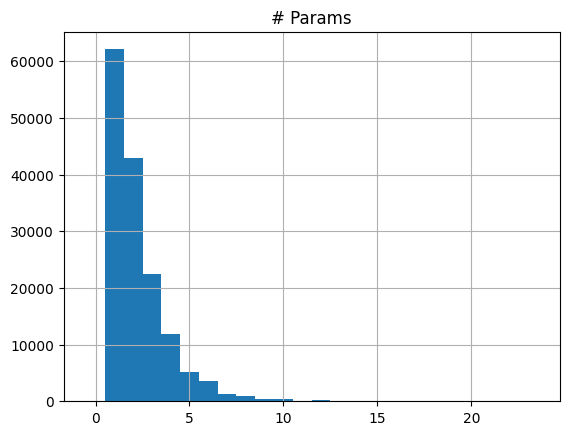

In [26]:
ax = df[(df.Vartype=='p')&(~df.IsReturnType_Debug)].groupby('FunctionStart').count()[['BinaryId']].rename({'BinaryId': '# Params'},axis=1).hist(
    # figsize=(18,5),
    bins=[x-0.5 for x in range(25)],
)
# ax[0][0].set_ylim([0, 500])

In [27]:
dataset_path

PosixPath('/home/cls0027/datasets/stateformer33')

In [28]:
# TODO: eval_model(dataset, model, filter_dataset=lambda df: df[df.HasDWARF])
# --> need to calculate the pred_df ONLY ONCE but allow multiple metrics/evals to occur

from typing import Callable

class EvalSubset:
    '''
    Represents a subset of the overall dataset that will be evaluated
    '''
    def __init__(self, name:str, filter_dataset:Callable[[pd.DataFrame], pd.DataFrame]) -> None:
        self.name = name
        self.filter_dataset = filter_dataset


In [29]:
acc_raw = len(mdf[mdf.TypeSeq_Debug==mdf.RawPred])/len(mdf)*100
acc_raw

54.77064940366228

In [30]:
len(df[(df.TypeSeq_Debug!='COMP')&(~df.IsReturnType_Debug)])

955415

In [31]:
# df['Label'] =
df.loc[df.TypeSeq_Debug=='COMP','Label'] = 'COMP'
df.loc[df.IsReturnType_Debug, 'Label'] = 'ReturnType'
df.Label = df.Label.fillna('Local/param')

In [32]:
#df = df.drop('Label', axis=1)

<Axes: xlabel='Label'>

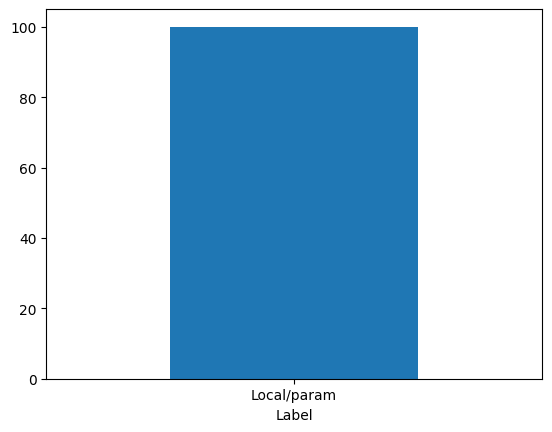

In [33]:
(df.groupby('Label').count().BinaryId/len(df)*100).plot(kind='bar', rot=0)


In [34]:
36992+15872+20

52884

In [35]:
counts = mdf.groupby('TypeSeq_Debug').count().BinaryId
# counts.sort_values()/len(mdf)
# counts.sort_index()

In [36]:
counts = mdf.groupby('TypeSeq_Debug').count()[['BinaryId']]
counts['TypeSeqLen'] = [len(x.split(',')) for x in counts.index]

In [37]:
# counts.sort_values('TSL').BinaryId/len(mdf)*100
order_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
counts.loc[order_idx]
(counts.pivot(columns='TypeSeqLen', values='BinaryId')/len(mdf)*100).loc[order_idx]

TypeSeqLen,1,2,3,4,5
TypeSeq_Debug,,,,,
ENUM,1.041537,NaN,NaN,NaN,NaN
STRUCT,1.916445,NaN,NaN,NaN,NaN
UNION,0.055787,NaN,NaN,NaN,NaN
char,2.426694,NaN,NaN,NaN,NaN
double,0.325513,NaN,NaN,NaN,NaN
...,...,...,...,...,...
"PTR,PTR,PTR,char",NaN,NaN,NaN,0.018631,NaN
"PTR,PTR,PTR,uchar",NaN,NaN,NaN,0.005233,NaN
"PTR,PTR,PTR,uint64",NaN,NaN,NaN,0.000105,NaN


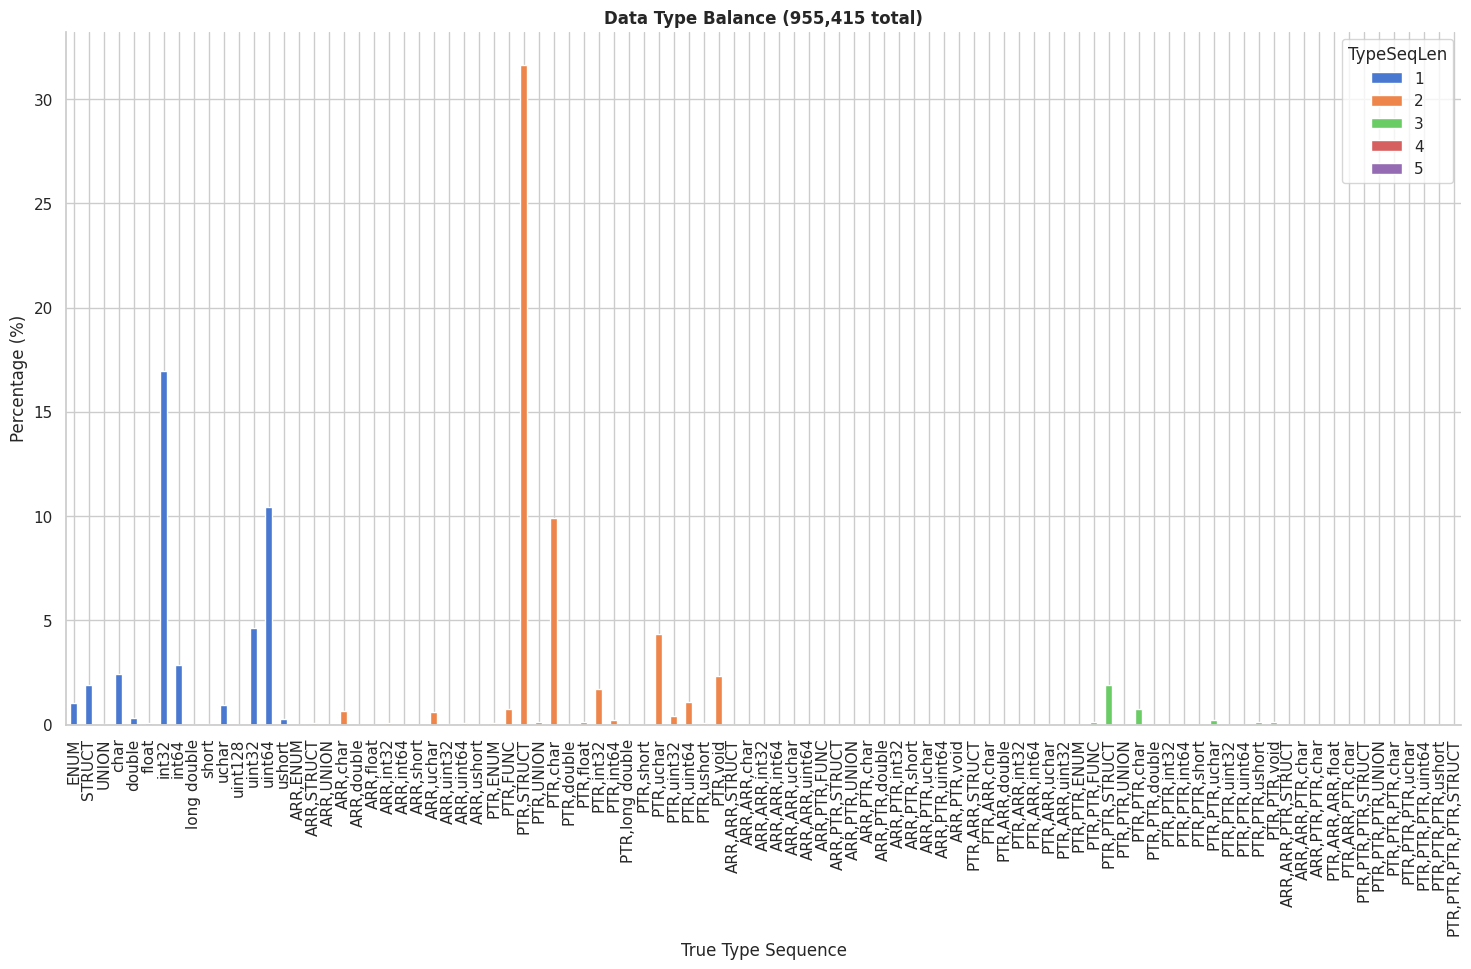

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns

# context: talk, notebook, paper, poster
# palette: muted, Paired, hls, husl, pastel, bright, deep, dark, colorblind
sns.set_theme(style='whitegrid', context='notebook', palette='muted')

order_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
bal_df = counts.pivot(columns='TypeSeqLen', values='BinaryId').loc[order_idx]/len(mdf)*100

ax = bal_df.plot(kind='bar', stacked=True, figsize=(18, 9))

ax.set_title(f'Data Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
ax.set_xlabel('True Type Sequence')#, fontweight='bold')
ax.set_ylabel('Percentage (%)')
# ax.set_ylim([0, 0.6])
sns.despine()

# Structure Balance

In [39]:
# mdf['HasSTRUCT'] = mdf.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)
# mdf.groupby('HasSTRUCT').count().BinaryId/len(mdf)*100
sns.set_theme(style='whitegrid', context='talk', palette='muted')# font='Ubuntu')

structs_df = (mdf.groupby(mdf.TypeSeq_Debug.apply(lambda x: 'STRUCT' in x)).count()[['BinaryId']]/len(mdf)*100)
structs_df = structs_df.transpose().reset_index(drop=True).rename({False: 'Other', True: 'STRUCT'},axis=1).rename({0: 'Balance'})
structs_df

TypeSeq_Debug,Other,STRUCT
Balance,64.370666,35.629334


(-0.5, 0.85)

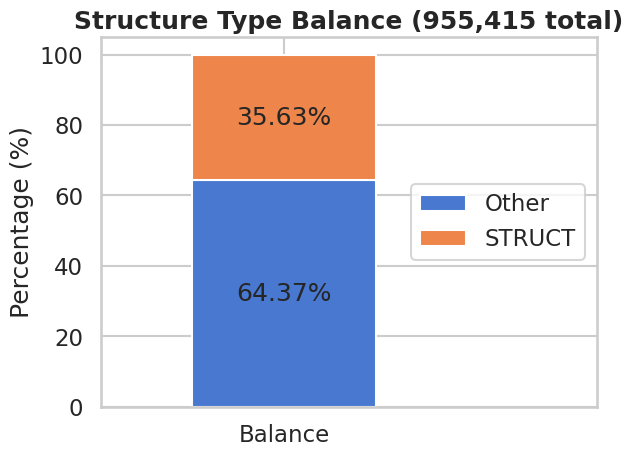

In [40]:
ax = structs_df.plot(kind='bar',
    # figsize=(8,8),
    xlabel='',
    ylabel='Percentage (%)',
    stacked=True,
    rot=0,
)
ax.legend(loc='right')
ax.set_title(f'Structure Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')
ax.set_xlim([-0.5, 0.85])

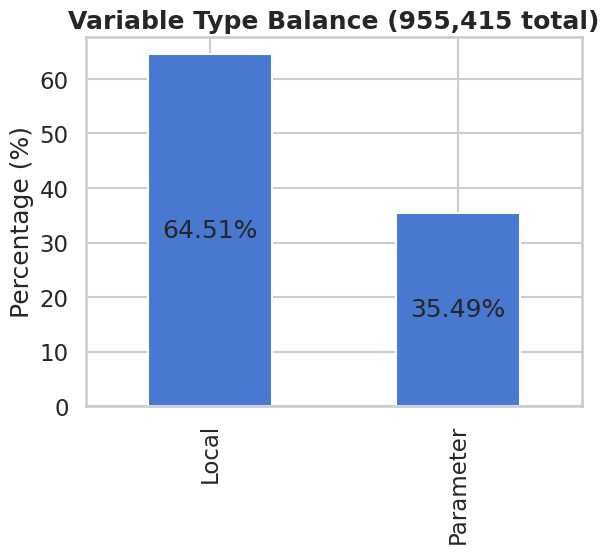

In [41]:
vtype_df = mdf.groupby('Vartype').count()[['BinaryId']]/len(mdf)*100
vtype_df.index = vtype_df.index.map({'l': 'Local', 'p': 'Parameter'})
ax = vtype_df.plot(kind='bar',
    xlabel='',
    ylabel='Percentage (%)',
    legend=False,
)
ax.set_title(f'Variable Type Balance ({len(mdf):,} total)', fontweight='bold')#, fontsize=16)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')

In [42]:
import pandas as pd

# pd.read_csv(dataset.root/dataset.raw_file_names[0])
from datatype_recovery.models.dataset import TypeSequenceDataset

ds = TypeSequenceDataset(dataset_path)

In [43]:
exp_runs = pd.read_csv(ds.exp_runs_path)
exp_runs

,RunGid,RunFolder,BinariesCsv,FuncsCsv,ParamsCsv,LocalsCsv
0,0,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
1,1,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
2,2,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
3,3,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
4,4,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
5,5,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
6,6,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
7,7,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
8,8,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...
9,9,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...,/home/cls0027/ex...


In [44]:
import pandas as pd
from pathlib import Path
bdf = pd.read_csv(Path.home()/'datasets/coreutils_5hops/raw/binaries.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/cls0027/datasets/coreutils_5hops/raw/binaries.csv'

In [ ]:
bdf[bdf.BinaryId==1010]

In [ ]:
ldf = pd.read_csv(Path.home()/'exp_builds/coreutils.exp/rundata/run1/locals.csv')
ldf[ldf.FunctionStart==0x10154b]

In [ ]:
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/ast_dumps/stripped/ | grep 10154
!echo ""
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/ast_dumps/stripped/ | grep 10154

# TODO: fix this logic - split on '-' and THEN match name.log

In [ ]:
!ls ~/exp_builds/coreutils.exp/rundata/run1/19.printenv/

fdf = pd.read_csv(Path.home()/'exp_builds/coreutils.exp/rundata/run1/19.printenv/functions.csv')
fdf[fdf.FunctionName_DWARF.isna()]
len(fdf.loc[fdf.FunctionName_DWARF.isna(),:])
len(fdf)
fdf.loc[fdf.FunctionName_DWARF.isna(),:]